# Intro

Generative Adversarial Networks are a Neural Network Structure with the ultimate purpose of generating output indistinguishable from the input data that the model was trained on. The model consists of two models, the generator and the discriminator. A useful analogy which conceptualizes how the model works is the cashier vs counterfeiter. The counterfeiter plays the role of the generator who produces the counterfeit currency and the discriminator is the cashier who tries to identify the real vs fake dollars. As the cashier improves their ability to spot fakes the counterfeiter improves producing the fakes. For the example below, the generator and discriminator of the GAN are built from two Convolutional Neural Networks, the generator produces a (64 x 64) RBG image and the discriminator uses a sigmoid function to output the probability of the image being real.   

# Import the necessary packages

In [1]:
import warnings

warnings.filterwarnings('ignore')

import cv2
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D, Dense, Conv2DTranspose
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np
from platform import python_version

# Check Python & Package versions

In [2]:
print("Package Versions");
print(f"cv2: {cv2.__version__}");
print(f"keras: {keras.__version__}")
print(f"numpy: {np.__version__}")
print(f"python:{python_version()}")

Package Versions
cv2: 4.5.5
keras: 2.6.0
numpy: 1.22.4
python:3.8.5


# Get Data

data sourced from Kaggle - (https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models) 

In [3]:
# Get Cat Faces
train_data = []

path = r'C:\Users\Aaron\cat faces\cats\cats'
for img in os.listdir(path):
    img_path = os.path.join(path, img)
    train = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    train_data.append(train)

In [4]:
# 64 X 64 image with RGB values for each pixel
train_data[0].shape

(64, 64, 3)

In [5]:
# Image in array form
train_data[0]

array([[[179, 172, 175],
        [164, 159, 161],
        [174, 170, 176],
        ...,
        [180, 183, 181],
        [219, 224, 223],
        [240, 245, 244]],

       [[218, 211, 214],
        [230, 225, 227],
        [186, 182, 187],
        ...,
        [221, 223, 223],
        [213, 218, 217],
        [150, 155, 154]],

       [[168, 161, 164],
        [206, 201, 203],
        [196, 192, 197],
        ...,
        [163, 165, 166],
        [123, 127, 128],
        [131, 135, 136]],

       ...,

       [[119, 135, 148],
        [113, 129, 142],
        [103, 119, 135],
        ...,
        [ 80,  95, 114],
        [ 81,  97, 114],
        [ 95, 111, 128]],

       [[118, 133, 149],
        [111, 126, 142],
        [ 99, 115, 131],
        ...,
        [ 66,  82,  99],
        [ 70,  86, 103],
        [ 93, 109, 126]],

       [[114, 129, 145],
        [107, 122, 138],
        [ 98, 114, 130],
        ...,
        [ 54,  70,  87],
        [ 72,  88, 105],
        [ 90, 106, 123]]

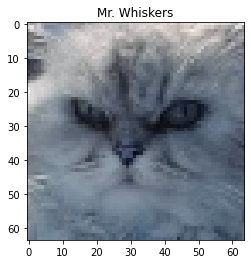

In [6]:
# Show Cat Face Example
plt.imshow(train_data[0],cmap=plt.cm.binary);
plt.title('Mr. Whiskers');

# Build Model

In [7]:
# Model Variables
img_width = 64
img_height = 64
channels = 3
img_shape = (img_width, img_height, channels)
latent_dim = 100 # Noise which will feed into model
adam = Adam(learning_rate=0.0002)

The image size variables and model optimizer with learning rate are set above. The generator below is a 2.7 million parameter and 5 layer CNN which takes random noise in the shape of and using the Conv2DTranspose we do a convolution (pixel pattern recognition) while "upscaling" the image to transform from noise to a (64x64x3) image.

In [8]:
def build_generator():
    model = Sequential()
    
    # Layer 1
    model.add(Dense(256 * 8* 8, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8,8,256)))
    
    # Layer 2
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 3
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 4
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #Layer 5
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  
    model.summary()

    return model

generator = build_generator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1654784   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0

The below code builds the discriminator which is a 1.5 million parameter and 5 layer CNN that intakes a (64 x 64 x 3) image and performs convolutions to eventually output a value between 0 and 1 which will represent our classification of if the generated image is real or fake. In addition, notice that the discriminator is being compiled, but not the generator. This is because the generator is trained along with the GAN and the discriminator will train separate from the GAN.

In [9]:
def build_discriminator():
    model = Sequential()
    
    # Layer 1
    model.add(Conv2D(64, (3,3), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 2
    model.add(Conv2D(128, (3,3), padding='same', ))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 3
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 4
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Layer 5
    model.add(Flatten())
    model.add(Dropout(0.4)) # Drop 40% of neurons
    model.add(Dense(1, activation='sigmoid')) 

    model.summary()
    return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 256)      

We combine the generator and discriminator into the GAN.

In [10]:
# Combine into one model
GAN = Sequential()
discriminator.trainable = False #discriminator weights don't train with GAN
GAN.add(generator)
GAN.add(discriminator)

GAN.compile(loss='binary_crossentropy', optimizer=adam)

# Save Generated Images during training

In [11]:
import glob
import imageio
import PIL

save_name = 0.00000000

def save_imgs(epoch):
    r, c = 4, 4
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)
    global save_name
    save_name += 0.00000001

    # Rescale images 0 - 1
    gen_imgs = (gen_imgs + 1) / 2.0

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("currentgeneration.png")
    fig.savefig(r"C:\Users\Aaron\cat faces\cats\generated_images\%.8f.png" % save_name)
    plt.close()

# Train Model

In [12]:
from PIL import Image

def train(train_data, epochs, batch_size=32, save_interval=200):
    X_train = np.array(train_data)

    bat_per_epo = int(X_train.shape[0] / batch_size)

    #Create our Y for our Neural Networks
    valid = np.ones((batch_size, 1))
    fakes = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        for j in range(bat_per_epo):
            
            #Get Random Batch
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            #Generate Fake Images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)

            #Train discriminator
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fakes)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
      
            #inverse y label
            g_loss = GAN.train_on_batch(noise, valid)

            print("******* %d %d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch,j, d_loss[0], 100* d_loss[1], g_loss))

            # if(epoch % save_interval) == 0:
        save_imgs(epoch)




In [13]:
#Training Model 
#train(train_data,5, batch_size=150, save_interval=1)

# Save Model Weights and Reload

The best part about GANs is the amount of time it takes to train these models. Due to the large number of model parameters the model experiences long model train times. Ensuring one's ability to save and reload a model for training later is important to get any worthwhile results. The generated image below is the result of 10hrs of training.

In [14]:
# Save model weights for training later
#generator.save_weights(r"C:\Users\Aaron\cat faces\cats\models\generator10hours.h5")

In [15]:
# Rebuild generator structure
generator = build_generator()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 128)      

In [16]:
# Load Generator's weights to the Generator
generator.load_weights(r"C:\Users\Aaron\cat faces\cats\models\generator10hours.h5")

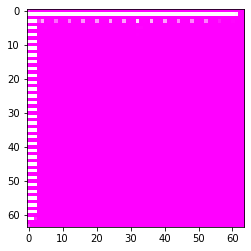

In [17]:
# Generate Image from Noise (Take 1)
noise = np.random.normal(0, 1, (16, latent_dim))
gen_imgs = generator.predict(noise)
gen_imgs = (gen_imgs + 1) / 2.0
plt.imshow(gen_imgs[2])